In [1]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import TensorBoard
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import datetime, os

import os
from tqdm import tqdm
import cv2
import seaborn as sn
import pandas as pd

In [2]:
labels = ['Human', 'Blank','Elephant_African', 'Hog_Red_River','Buffalo_African','Leopard_African','Monkey','Duiker_Blue','Duiker_Red','Porcupine_Brush_Tailed','Rodent','Squirrel','Rat_Giant','Guineafowl_Crested','Duiker_Yellow_Backed','Guineafowl_Black','Mongoose','Rail_Nkulengu','Mammal_Other','Chimpanzee','Bird','Genet','Gorilla','Pangolin','Mongoose_Black_Footed','Mandrillus','Civet_African_Palm','Chevrotain_Water','Cat_Golden']

In [3]:
label_count = {'Human': 34999, 'Blank': 35000, 'Elephant_African': 34999, 'Hog_Red_River': 26069, 'Buffalo_African': 6459, 'Leopard_African': 2142, 'Monkey': 5038, 'Duiker_Blue': 35000, 'Duiker_Red': 34999, 'Porcupine_Brush_Tailed': 13694, 'Rodent': 1358, 'Squirrel': 11348, 'Rat_Giant': 34225, 'Guineafowl_Crested': 1513, 'Duiker_Yellow_Backed': 15436, 'Guineafowl_Black': 12054, 'Mongoose': 5518, 'Rail_Nkulengu': 3269, 'Chimpanzee': 5260, 'Bird': 6649, 'Genet': 3303, 'Gorilla': 1074, 'Pangolin': 872, 'Mongoose_Black_Footed': 1475, 'Mandrillus': 9305, 'Civet_African_Palm': 936, 'Chevrotain_Water': 4713, 'Cat_Golden': 406}

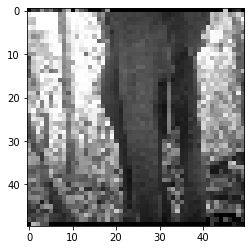

In [4]:
data = np.load("../Data/Data_Gabon/training_data_gabon.npy", allow_pickle=True)
plt.imshow(data[2][0], cmap="gray")
plt.show()

In [5]:
# change duiker_blue and red to duiker
for picture in data:
    if picture[1] == 8:
        picture[1] = 7

In [6]:
new_data = []
counter = {}
for picture in data:
    if label_count[labels[picture[1]]] < 5000:
        pass
    else:
        if picture[1] in counter.keys():
            new_data.append(picture)
            counter[picture[1]] += 1
        else:
            new_data.append(picture)
            counter[picture[1]] = 1

In [7]:
# relabel data
new_labels = []
for key in counter.keys():
    new_labels.append(labels[key])                     
    
for item in new_data:
    item[1] = new_labels.index(labels[item[1]])

print(new_labels)

['Mongoose', 'Chimpanzee', 'Elephant_African', 'Duiker_Blue', 'Hog_Red_River', 'Rat_Giant', 'Blank', 'Duiker_Yellow_Backed', 'Human', 'Guineafowl_Black', 'Porcupine_Brush_Tailed', 'Mandrillus', 'Squirrel', 'Bird', 'Monkey', 'Buffalo_African']


In [8]:
def create_set(new_data, amount):
    data = []
    second_count = {}
    count = 0
    for item in new_data:
        if item[1] in second_count.keys():
            if second_count[item[1]] >= amount:
                pass
            else:
                data.append(new_data.pop(count))
                second_count[item[1]] += 1
        else:
            data.append(new_data.pop(count))
            second_count[item[1]] = 1
        count += 1
        
    # Normalize pixel values to be between 0 and 1
    for pictures in data:
        pictures[0] = pictures[0] / 255

    return data

val_data = create_set(new_data, 2000)
test_data = create_set(new_data, 2000)

In [9]:
new_count = {}
for picture in new_data:
    if picture[1] in new_count.keys():
        new_count[picture[1]] += 1
    else:
        new_count[picture[1]] = 1
print(new_count)

{3: 65999, 6: 31000, 5: 30225, 8: 30999, 2: 30999, 10: 9694, 11: 5305, 12: 7348, 9: 8054, 7: 11436, 14: 1038, 0: 1518, 4: 22069, 15: 2459, 13: 2649, 1: 1260}


In [10]:
# creates a data generator object that transforms images
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [11]:
# create empty dict and add data augmentation
count_train = {}
for key in new_count.keys():
    count_train[key] = 0

train_data = []
for picture in tqdm(new_data):
    if new_count[picture[1]] >= 10000:
        if count_train[picture[1]] < 10000:
            train_data.append(picture)
            count_train[picture[1]] += 1
    else:
        if count_train[picture[1]] < 10000:
            train_data.append(picture)
            count_train[picture[1]] += 1
            
            img = image.img_to_array(picture[0])  # convert image to numpy arry
            img = img.reshape((1,) + img.shape)  # reshape image

            amount_of_augmentations = 10000 // new_count[picture[1]]
            i = 0
            for batch in datagen.flow(img):
                augment_image = tf.reshape(batch[0], picture[0].shape)
                train_data.append([augment_image, picture[1]])
                count_train[picture[1]] += 1
                i += 1
                if i >= amount_of_augmentations: 
                    break
print(count_train)        
        

100%|██████████| 262052/262052 [00:27<00:00, 9382.25it/s] 

{3: 10000, 6: 10000, 5: 10000, 8: 10000, 2: 10000, 10: 10000, 11: 10000, 12: 10000, 9: 10000, 7: 10000, 14: 10000, 0: 10003, 4: 10000, 15: 10000, 13: 10000, 1: 10000}


In [12]:
# Normalize pixel values to be between 0 and 1
for pictures in train_data:
    pictures[0] = pictures[0] / 255

# train model

In [13]:
# get the labels
def get_labels(data):
    images, labels = [], []
    for items in data:
        images.append(items[0])
        labels.append(items[1])
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

X_train, y_train = get_labels(train_data)
X_val, y_val = get_labels(val_data)
X_test, y_test = get_labels(test_data)

In [14]:
print(len(new_labels))

16


In [15]:
len(train_data)

160003

In [16]:
# reduce dimentions
X_train = tf.expand_dims(X_train, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)
X_val = tf.expand_dims(X_test, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)
y_val = tf.expand_dims(y_test, axis=-1)

In [17]:
# creating the model
model = models.Sequential()
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16)) # <---- change ending layers!!!

model.summary()  # summary

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 15488)             0         
_________________________________________________________________
dropout (Dropout)            (None, 15488)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [ ]:
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# With tensorboard
history = model.fit(X_train, y_train, epochs=3, batch_size = 32,
                    validation_data=(X_val, y_val))

# With tensorboard
# history = model.fit(X_train, y_train, epochs=10, batch_size = 32,
#                     validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

Epoch 1/3
1509/5001 [========>.....................] - ETA: 7:21 - loss: 1.5988 - accuracy: 0.4463

In [223]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

1063/1063 [==============================] - 60s 56ms/step - loss: 1.2010 - accuracy: 0.59870s
0.5987352728843689


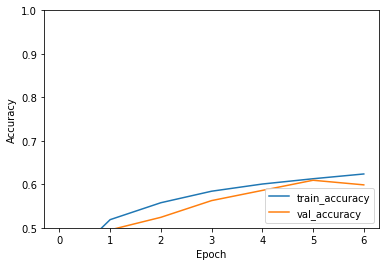

In [218]:
# plot results
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

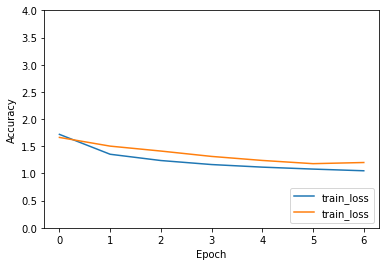

In [220]:
# plot results
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 4])
plt.legend(loc='lower right')

In [222]:
# score per class
Y_test = tf.reshape(y_test, [34000])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes()
y_pred = np.argmax(model.predict(X_test), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.05      0.09      2000
           1       0.84      0.55      0.67      2000
           2       0.48      0.80      0.60      2000
           3       0.34      0.54      0.41      2000
           4       0.77      0.81      0.79      2000
           5       0.58      0.93      0.71      2000
           6       0.68      0.82      0.74      2000
           7       0.71      0.86      0.78      2000
           8       0.70      0.66      0.68      2000
           9       0.68      0.81      0.74      2000
          10       0.36      0.49      0.42      2000
          11       0.80      0.38      0.52      2000
          12       0.63      0.93      0.75      2000
          13       0.48      0.53      0.50      2000
          14       0.56      0.37      0.45      2000
          15       0.61      0.09      0.15      2000
          16       0.95      0.57      0.71      2000

    accuracy              

<AxesSubplot:>

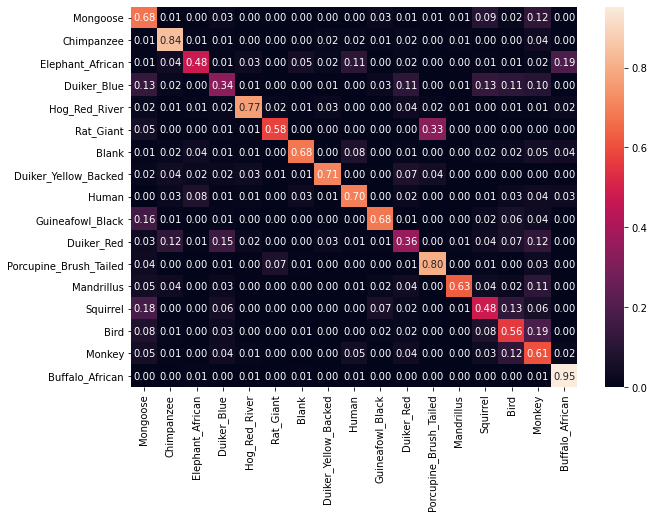

In [226]:
y_pred = model.predict(X_test)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in y_test], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

df_cm = pd.DataFrame(cmn, index = [i for i in new_labels],
                  columns = [i for i in new_labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')

In [50]:
# model.save('Models/model_V3.h5')

In [51]:
# # Convert the model.
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('Models/model.tflite', 'wb') as f:
#     f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Siebren\AppData\Local\Temp\tmpdne0r9fn\assets


# Test on myanmar data

0


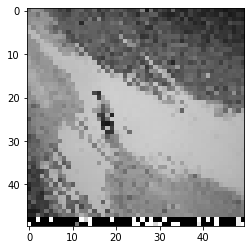

In [120]:
myanmar_data = np.load("../Data/Data_Myanmar/testing_data_myanmar_for_gabon_model.npy", allow_pickle=True)
i = 5
plt.imshow(myanmar_data[i][0], cmap="gray")
print(myanmar_data[i][1])
plt.show()

In [121]:
pictures_myan = []
labels_myan = []

# Normalize pixel values to be between 0 and 1
for pic in myanmar_data:
    pic[0] = pic[0] / 255

for picture_myan, label_myan in myanmar_data:
    pictures_myan.append(picture_myan)
    labels_myan.append(label_myan)

In [122]:
pictures_myan = np.array(pictures_myan)
labels_myan = np.array(labels_myan)

pictures_myan = tf.expand_dims(pictures_myan, axis=-1)
labels_myan = tf.expand_dims(labels_myan, axis=-1)

In [123]:
test_loss, test_acc = model.evaluate(pictures_myan, labels_myan, verbose=1)
print(test_acc)

92/92 [==============================] - 3s 29ms/step - loss: 1.0942 - accuracy: 0.6223
0.6222677826881409


In [124]:
# score per class
Y_test = tf.reshape(labels_myan, [2928])
# Y_test = np.argmax(y_pred, axis=1) # Convert one-hot to index
y_pred = model.predict_classes(pictures_myan)
# np.argmax(model.predict(pictures_myan), axis=-1)

print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77      2562
           1       0.03      0.04      0.03       274
           2       0.09      0.48      0.16        92

    accuracy                           0.62      2928
   macro avg       0.33      0.40      0.32      2928
weighted avg       0.76      0.62      0.68      2928



In [125]:
predictions = model.predict_on_batch(pictures_myan)

In [126]:
correct_zero, correct_one, correct_two = 0, 0, 0
for i in range(len(predictions)):
    if Y_test[i].numpy() != predictions[i].argmax():
        print("correct: " + str(Y_test[i].numpy()) + " pred: " + str(predictions[i].argmax()))
        print("---------------------")
    else:
        if Y_test[i].numpy() == 0:
            correct_zero += 1
        elif Y_test[i].numpy() == 1:
            correct_one += 1
        elif Y_test[i].numpy() == 2:
            correct_two += 1

correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 2 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 2 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

correct: 1 pred: 0
---------------------
correct: 2 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 2 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 2 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred:

correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 2
---------------------
correct: 0 pred: 2
---------------------
correct: 1 pred: 0
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred: 1
---------------------
correct: 0 pred:

In [127]:
count_zero, count_one, count_two = 0, 0, 0
for label in labels_myan:
    if label == 0:
        count_zero += 1
    elif label == 1:
        count_one += 1
    elif label == 2:
        count_two += 1
print("zero " + str(count_zero) + " / " + str(correct_zero))
print("one " + str(count_one) + " / " + str(correct_one))
print("two " + str(count_two) + " / " + str(correct_two))

zero 2562 / 1766
one 274 / 12
two 92 / 44


<AxesSubplot:>

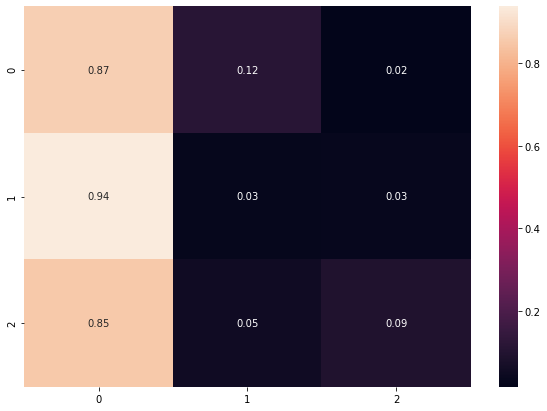

In [128]:
y_pred = model.predict(pictures_myan)
predicted_categories = tf.argmax(y_pred, axis=1)
true_categories = tf.concat([y for y in labels_myan], axis=0)
cm = confusion_matrix(predicted_categories, true_categories)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalized

class_names = [0, 1, 2]

df_cm = pd.DataFrame(cmn, index = [i for i in class_names],
                  columns = [i for i in class_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='.2f')